In [1]:
!pip install -q datasets flash_attn timm einops bitsandbytes accelerate

In [2]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
import torch
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
import requests
import copy
%matplotlib inline


# HF Login
To loggin to Hugging Face from notebook, you need:
  1. Register account with https://huggingface.co/
  2. Go to your account, select Setting --> Access Token --> Create new token --> copy the token to paste here

In [1]:
from huggingface_hub import notebook_login
notebook_login()

# Load the model and processor
Reference to : https://huggingface.co/microsoft/Florence-2-large




In [4]:
model_id = 'microsoft/Florence-2-large'

In [5]:
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             trust_remote_code=True,
                                             device_map='cuda')
print(model)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Florence2ForConditionalGeneration(
  (vision_tower): DaViT(
    (convs): ModuleList(
      (0): ConvEmbed(
        (proj): Conv2d(3, 256, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (1): ConvEmbed(
        (proj): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (2): ConvEmbed(
        (proj): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (3): ConvEmbed(
        (proj): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (blocks): ModuleList(
      (0): MySequential(
        (0): MySequential(
          (spatial_block): SpatialBlock(
            (conv1): PreNorm(
              (fn): De

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
# Reference to : https://huggingface.co/microsoft/Florence-2-large
def run_example(task_prompt, image):
    inputs = processor(text=task_prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [7]:
from google.colab import files
uploaded = files.upload()

Saving boris-smokrovic-DPXytK8Z59Y-unsplash.jpg to boris-smokrovic-DPXytK8Z59Y-unsplash (1).jpg


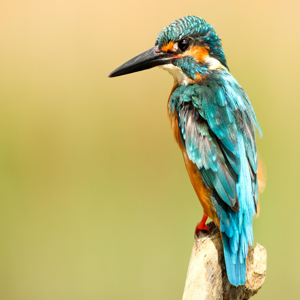

In [8]:
image_path = "boris-smokrovic-DPXytK8Z59Y-unsplash.jpg"
image = Image.open(image_path)

resized_image = image.resize((300, 300))
display(resized_image)

# Captioning

In [9]:
task_prompt = '<CAPTION>'
run_example(task_prompt,resized_image)

{'<CAPTION>': 'A small bird sitting on top of a wooden post.'}

In [10]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt, image)

{'<DETAILED_CAPTION>': 'The image shows a Eurasian kingfisher (Alcedo atthis) with its vibrant blue, orange, white, black and green feathers standing out against a cream-colored background.'}

To process the location tokens and render them on the image, the following method will be called to plot bounding boxes.

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bbox(image, key):
    # Extract data from the results dictionary using the provided key
    data = results[key]

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()


In [12]:
task_prompt = '<OD>'
results = run_example(task_prompt,resized_image)
print(results)

{'<OD>': {'bboxes': [[108.1500015258789, 15.750000953674316, 268.3500061035156, 285.45001220703125]], 'labels': ['bird']}}


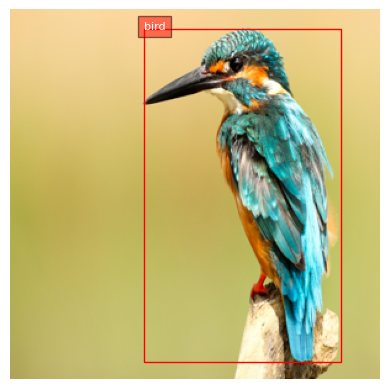

In [13]:
key = list(results.keys())[0]
plot_bbox(resized_image, key)

# Data preparation
We load dataset from https://huggingface.co/datasets/sammarfy/VLM4Bio

In [14]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader

In [15]:
dataset = load_dataset('sammarfy/VLM4Bio', 'Bird')

In [16]:
print(dataset.keys())


dict_keys(['species_classification', 'species_classification_easy', 'species_classification_medium', 'species_classification_prompting'])


In [23]:
for key in dataset.keys():
    print(dataset[key][:2])

{'fileNameAsDelivered': ['Black_Footed_Albatross_0046_18.jpg', 'Black_Footed_Albatross_0009_34.jpg'], 'scientificName': ['Phoebastria nigripes', 'Phoebastria nigripes']}
{'fileNameAsDelivered': ['American_Crow_0053_25203.jpg', 'American_Crow_0101_25118.jpg'], 'scientificName': ['Corvus brachyrhynchos', 'Corvus brachyrhynchos']}
{'fileNameAsDelivered': ['Bay_Breasted_Warbler_0026_159744.jpg', 'Bay_Breasted_Warbler_0062_159783.jpg'], 'scientificName': ['Setophaga castanea', 'Setophaga castanea']}
{'fileNameAsDelivered': ['White_Necked_Raven_0019_797377.jpg', 'White_Necked_Raven_0062_797382.jpg'], 'scientificName': ['Corvus albicollis', 'Corvus albicollis']}


In [24]:
import os

class BirdDataset(Dataset):
    def __init__(self, data, image_path):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Extract file names and scientific names
        file_names = item['fileNameAsDelivered']
        scientific_names = item['scientificName']

        # Create questions and answers (for simplicity, just use the first file and name)
        question = f"What is the scientific name of this bird?"
        answer = scientific_names[0]

        # Load the image
        image_path = file_names[0]
        if os.path.exists(image_path):
            image = Image.open(image_path).convert("RGB")

        return question, answer, image